<a href="https://colab.research.google.com/github/arpdm/predictive-maintenance-platform/blob/main/PdM_NASA_ENGINES_003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
"""
    Project Name: PdM Model for NASA Jet Engines
    Data: 10/9/2022
    Author: Arpi Derm
    Description: This model aims to use PdM model and RUL to predict failures in point time T in near future.
                 This specific model is built and trained for the NASA's PCoE Turbofan Engine Degradation (Run-To-Failure) dataset.
    Dataset Description: 
                Dataset description along with its variable can be found in the dataset paper written by 
                Manuel Arias Chao,Chetan Kulkarni, Kai Goebel and Olga Fink. https://dx.doi.org/10.3390/data6010005
    Variable Name Descriptions:
            w = Scenario-descriptor operating conditions (inputs to system model)
            x_s = sensor signal measurements (physical properties)
            x_v = virtual sensor signals
            t = engine health parameters 
            y_rul = target output Y - RUL (Remanding Useful Life) of engine unit
            aux = Auxiliary data such as cycle count, unit id, ...

    Notebook horizon with multiple cycles in advance
    https://colab.research.google.com/drive/1SGsU5jyuJVodUwAhf3Budeyh7c-gHXOR?usp=sharing#scrollTo=mXTILGKqWks0 

    Custom Learning Rate Scheduler
    https://colab.research.google.com/drive/1ceEa9Rs4BdGrfXfidwx-BpG-gtproWdQ#scrollTo=y6kJd40-0Hj9 
"""

# Colab data file preparation
from google.colab import drive

drive.mount("/content/drive/")

!cp drive/MyDrive/PdM/predictive-maintenance-platform/engine_data.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/plot_util.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/mark_001_model.py .
!cp drive/MyDrive/PdM/predictive-maintenance-platform/pcoe_engine_data_visualizer.py .


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import tensorflow as tf

from engine_data import EngineData
from pcoe_engine_data_visualizer import PcoeEngingeVis
from plot_util import PlotUtil
from mark_001_model import Mark001Model

In [3]:
# Load all datasets
BASE_PATH = "/content/drive/MyDrive/PdM/data_set/"

DS_001 = BASE_PATH + "N-CMAPSS_DS01-005.h5"
DS_002 = BASE_PATH + "N-CMAPSS_DS02-006.h5"
DS_003 = BASE_PATH + "N-CMAPSS_DS03-012.h5"
DS_004 = BASE_PATH + "N-CMAPSS_DS04.h5"
DS_005 = BASE_PATH + "N-CMAPSS_DS05.h5"
DS_006 = BASE_PATH + "N-CMAPSS_DS06.h5"
DS_007 = BASE_PATH + "N-CMAPSS_DS07.h5"
DS_008 = BASE_PATH + "N-CMAPSS_DS08a-009.h5"
DS_009 = BASE_PATH + "N-CMAPSS_DS08c-008.h5"
DS_010 = BASE_PATH + "N-CMAPSS_DS08d-010.h5"

In [4]:
# Load data set and prepare data frames
ed = EngineData()
pcoe_enging_vis = PcoeEngingeVis(ed)
plot_util = PlotUtil()
mark_001 = Mark001Model()

# Load Data from selected dataset file
ed.load_hdf5_to_numpy_arr(DS_004)

Process data for NASA's engines run-to-failure datasets
Data analyzer and visualizer.
Utility file for generic plotting and visualization
Different PdM model collection to be tested.


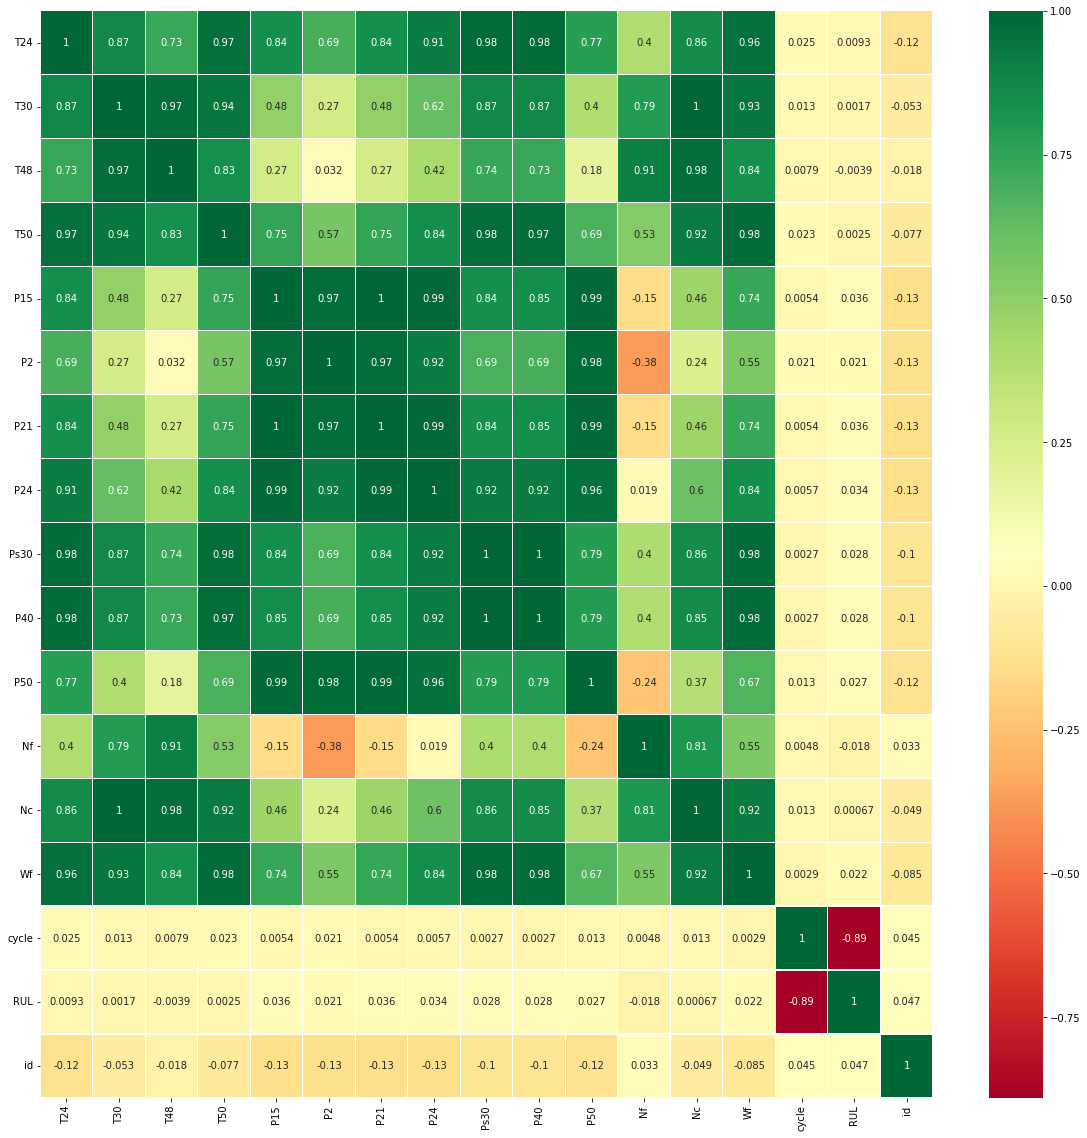

In [5]:
# Generate heatmap of sensor measurements dataframe to find correlation between each feature
plot_util.generate_correlation_heatmap(ed.df_x_s_train)

In [6]:
# Add labels to training dataset and normalize data
ed.df_x_s_train = ed.add_labels_to_dataset(ed.df_x_s_train)
ed.df_x_s_train = ed.normalize_dataset(ed.df_x_s_train)

# Add lavels to test dataset and normalize data
ed.df_x_s_test = ed.add_labels_to_dataset(ed.df_x_s_test)
ed.df_x_s_test = ed.normalize_dataset(ed.df_x_s_test)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['str', 'str_']. An error will be raised in 1.2.
  FutureWarning,


## MODELING

The traditional predictive maintenance machine learning models are based on feature engineering which is manual construction of right features using domain expertise and similar methods. This usually makes these models hard to reuse since feature engineering is specific to the problem scenario and the available data which varies from one business to the other. Perhaps the most attractive part of applying deep learning in the predictive maintenance domain is the fact that these networks can automatically extract the right features from the data, eliminating the need for manual feature engineering.

he idea of using LSTMs is to let the model extract abstract features out of the sequence of sensor values in the window rather than engineering those manually. The expectation is that if there is a pattern in these sensor values within the window prior to failure, the pattern should be encoded by the LSTM.

One critical advantage of LSTMs is their ability to remember from long-term sequences (window sizes) which is hard to achieve by traditional feature engineering. For example, computing rolling averages over a window size of 50 cycles may lead to loss of information due to smoothing and abstracting of values over such a long period, instead, using all 50 values as input may provide better results. While feature engineering over large window sizes may not make sense, LSTMs are able to use larger window sizes and use all the information in the window as input. 
LSTM also has this long term memory over regular RNN architecture.

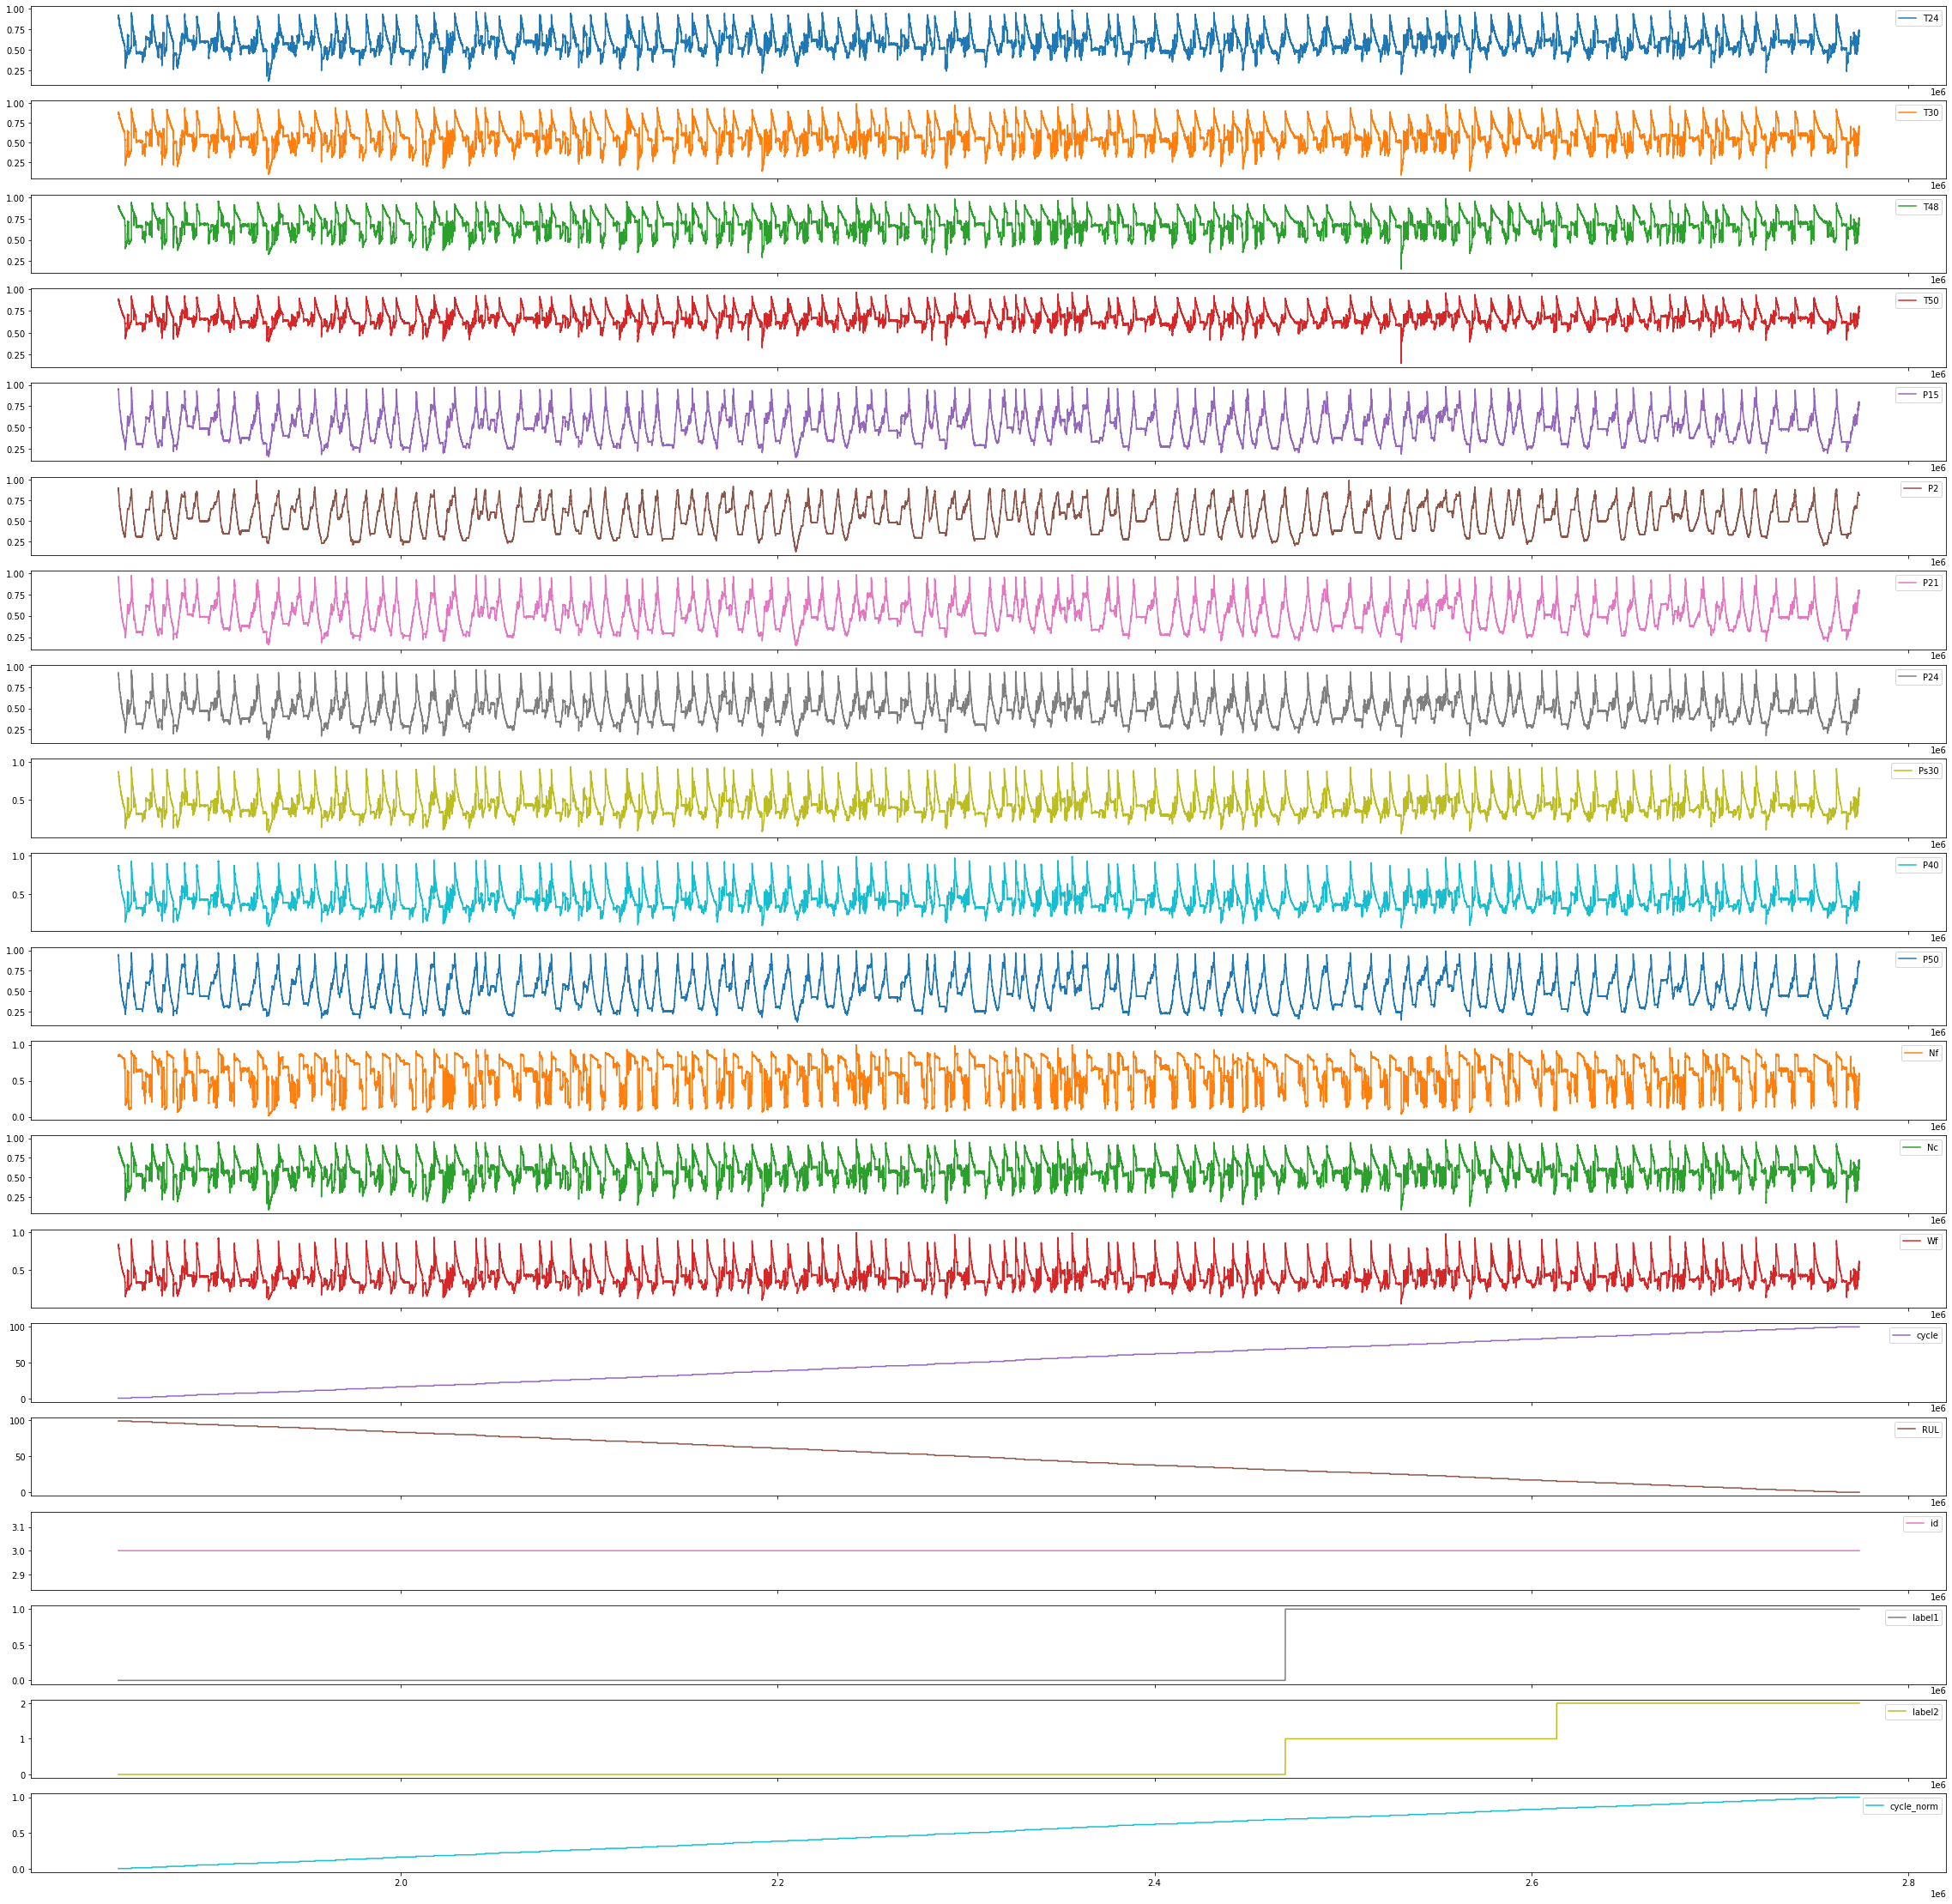

In [7]:
# Get single engine data for training and test datasets
single_engine_train = ed.generate_data_frame_for_specific_engine(ed.df_x_s_train, 3)
single_engine_test = ed.generate_data_frame_for_specific_engine(ed.df_x_s_test, 7)

# window of 50 cycles prior to a failure point for engine id 3
engine_id3_windowed = ed.generate_data_frame_for_specific_engine(ed.df_x_s_train, 3, 50)
ax1 = engine_id3_windowed.plot(subplots=True, sharex=True, figsize=(40,40))

In [8]:
window = 50
horizon = 5
batch_size = 256
buffer_size = 150

epochs = 40
steps = 100
patience_epoch = 10
data_path = "/content/drive/MyDrive/PdM/model_generated_data"

# Prepare X and Y training and test sets
x_train, y_train = ed.generate_x_y_model_inputs(single_engine_train)
x_test, y_test = ed.generate_x_y_model_inputs(single_engine_test)

features = x_train.shape[2]
model_mark_001 = mark_001.create_binary_classifier_model(window, features, units_first_layer = 100, units_second_layer= 50, dropout_rate= 0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 100)           46400     
                                                                 
 dropout (Dropout)           (None, 50, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                30200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 76,651
Trainable params: 76,651
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Fit the model
mark_001_history = mark_001.fit_model(x_train, y_train, epochs, steps, batch_size, patience_epoch)

Epoch 1/40
100/100 [==============================] - 7s 27ms/step - loss: 0.1614 - accuracy: 0.9287 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 2/40
100/100 [==============================] - 2s 18ms/step - loss: 0.0505 - accuracy: 0.9789 - val_loss: 0.0046 - val_accuracy: 1.0000
Epoch 3/40
100/100 [==============================] - 2s 18ms/step - loss: 0.0372 - accuracy: 0.9849 - val_loss: 0.0017 - val_accuracy: 1.0000
Epoch 4/40
100/100 [==============================] - 2s 18ms/step - loss: 0.0569 - accuracy: 0.9790 - val_loss: 0.0029 - val_accuracy: 1.0000
Epoch 5/40
100/100 [==============================] - 2s 18ms/step - loss: 0.0646 - accuracy: 0.9723 - val_loss: 0.0021 - val_accuracy: 1.0000
Epoch 6/40
100/100 [==============================] - 2s 18ms/step - loss: 0.0429 - accuracy: 0.9827 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/40
100/100 [==============================] - 2s 18ms/step - loss: 0.0430 - accuracy: 0.9826 - val_loss: 0.0024 - val_accuracy: 1.0000

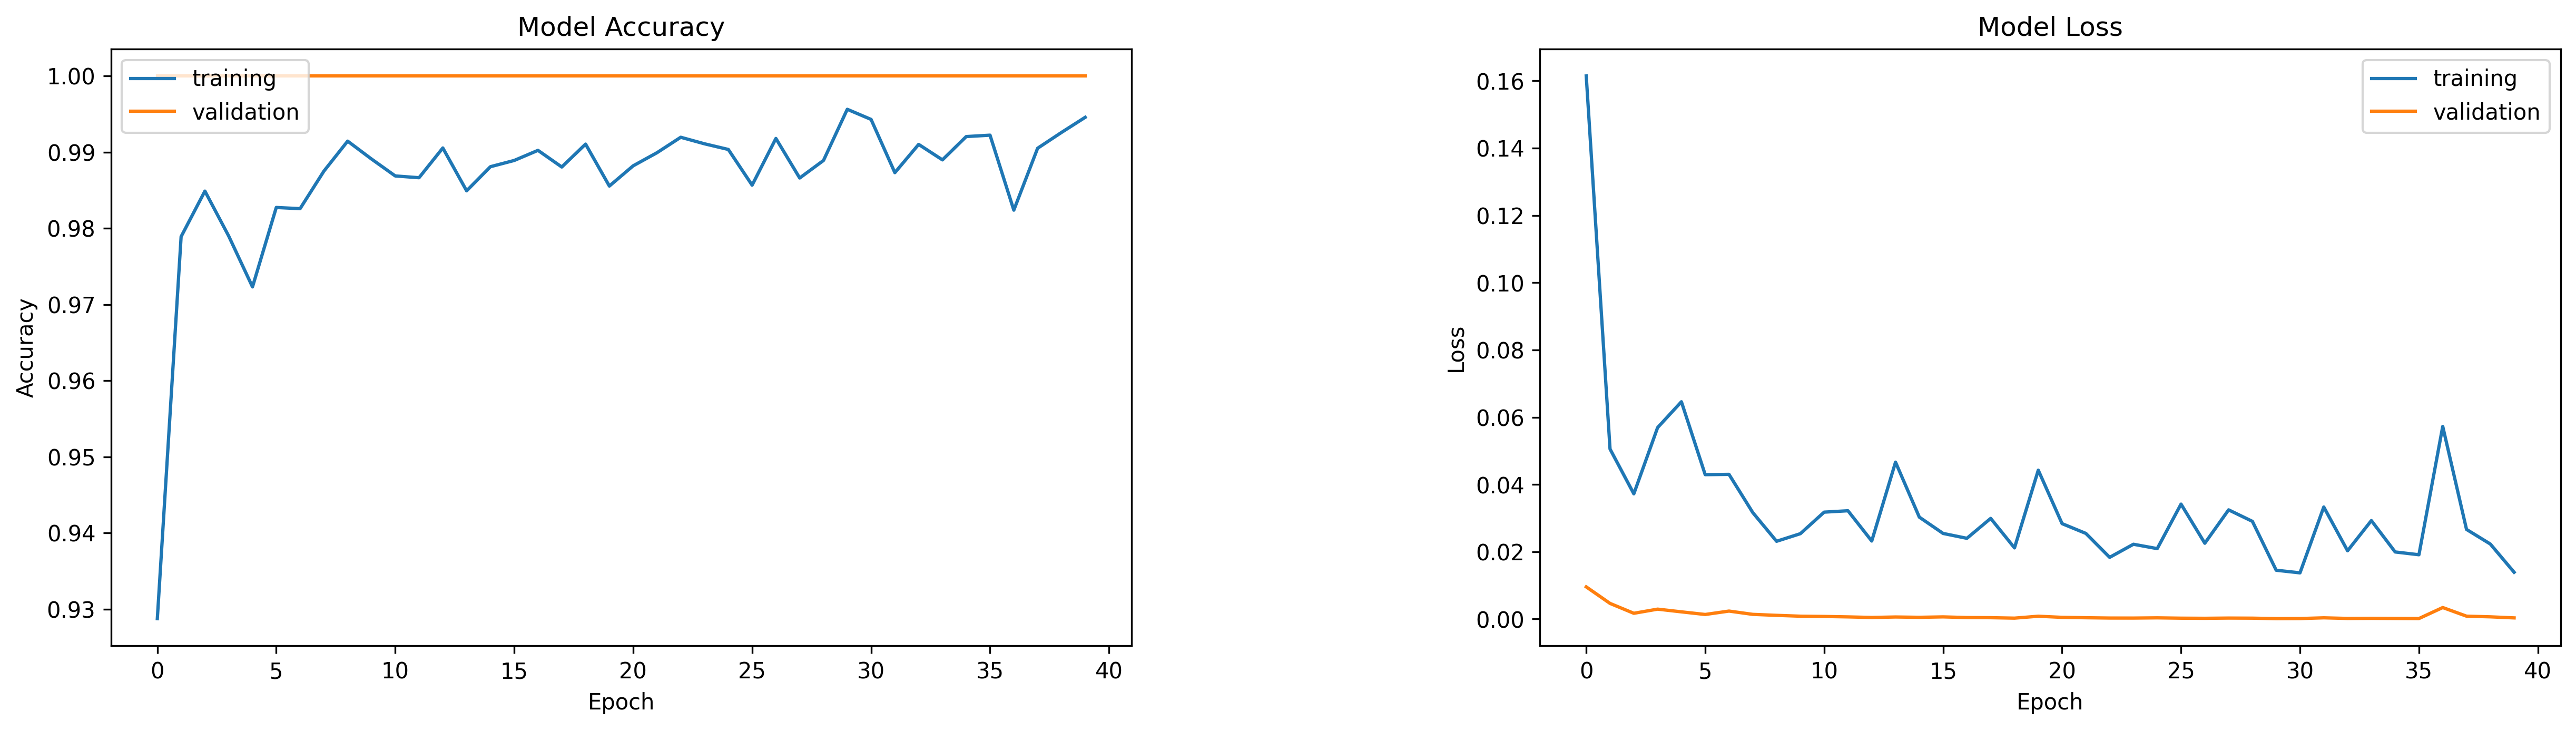

In [10]:
# Generate accuracy and loss plots based on fitting history and save it to drive
plot_util.generate_training_history_accuracy_and_loss_plot(mark_001_history, data_path)

In [11]:
mark_001.save_model(mark_001_history, data_path, "mark_001")

Saved model to disk


In [12]:
mark_001.evaluate_model(x_train, y_train, batch_size)

3610/3610 [==============================] - 18s 5ms/step - loss: 0.0612 - accuracy: 0.9763
Accuracy of predictions made on data used for training:
0.9763002991676331


In [13]:
(y_pred,y_true, cm) = mark_001.test_model(x_test, y_test)

25668/25668 [==============================] - 89s 3ms/step

Accuracy of model on test data = 0.8492831296843725

Recall = 0.5751459469477268

MAE Loss = [0.15071687]


,0,1
0,529975,0
1,123791,167582


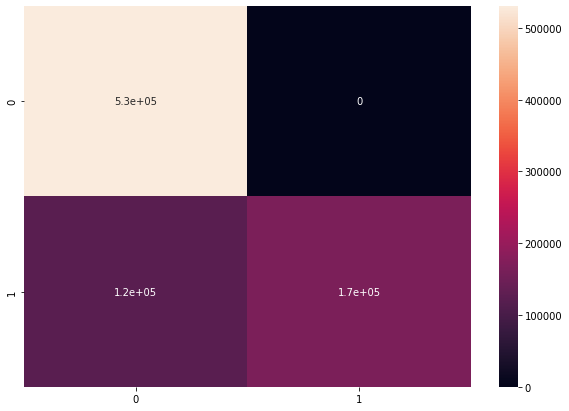

In [15]:
plot_util.generate_heat_map(cm)
cm.head()

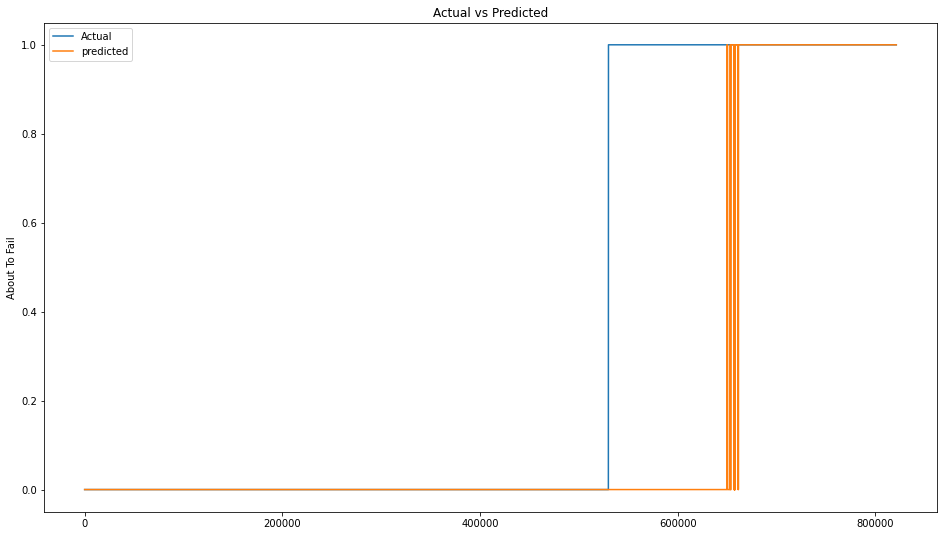

In [17]:
plot_util.generate_predicted_vs_true_plot(y_true, y_pred, "About To Fail")

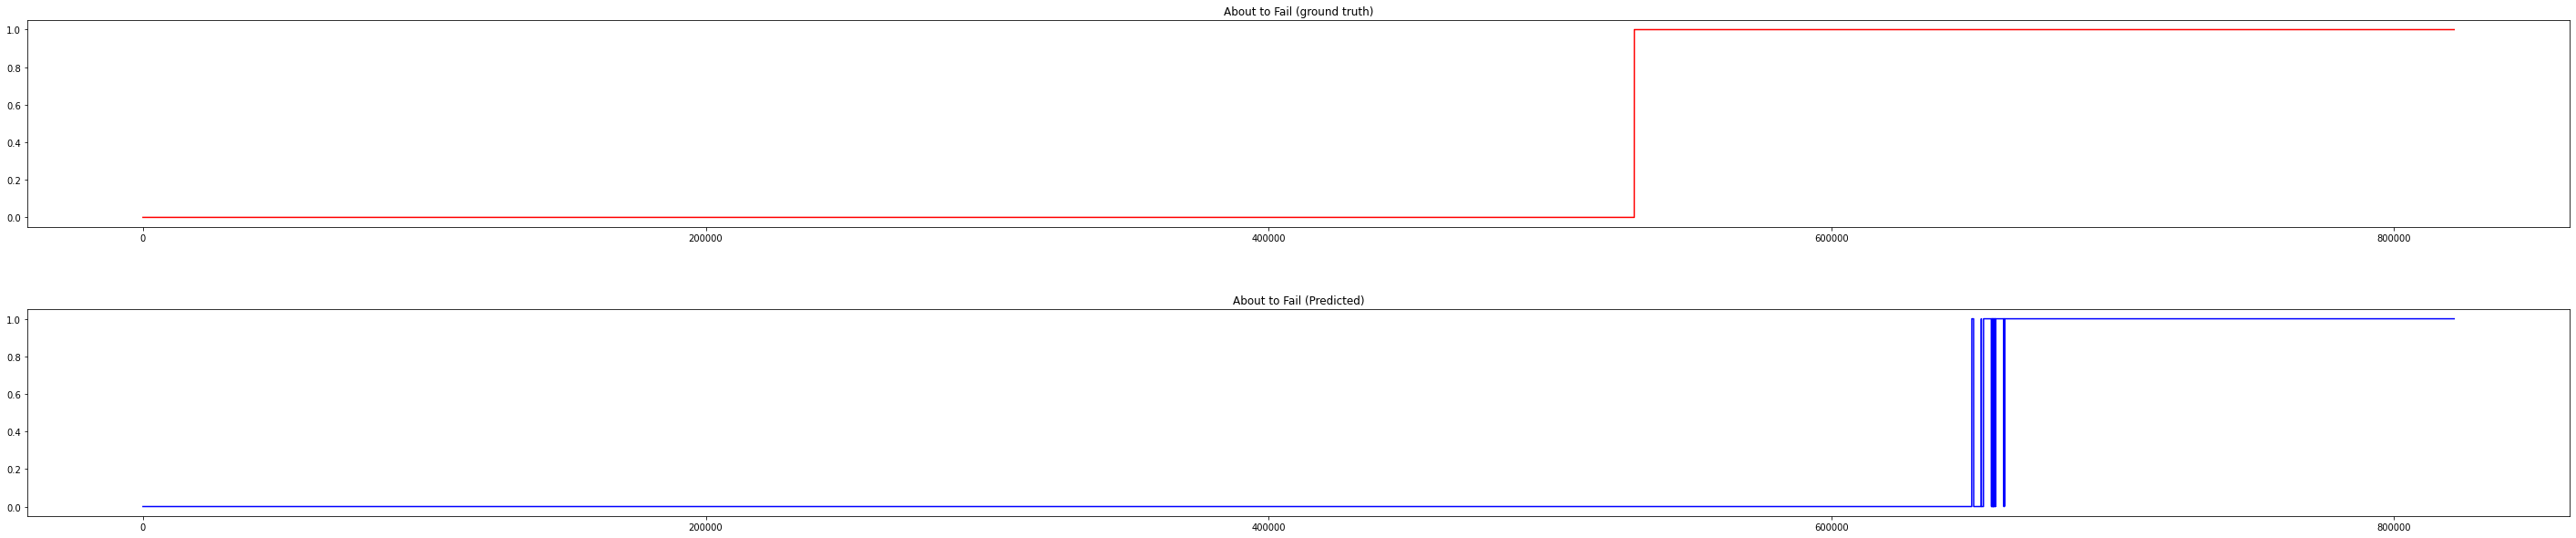

In [18]:
plot_util.generate_about_to_fail_graphs(y_true, y_pred)